In [37]:
# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt

# Chocolate imports
from src.Calculators.ray_maker import find_observer, ray_maker
from src.Luminosity.thermR import calc_thermr
from src.Opacity.opacity_table import opacity

# Constants
c = 2.99792458e10 #[cm/s]
h = 6.62607015e-27 #[gcm^2/s]
Kb = 1.380649e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10

In [8]:
def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr

def select_fix(m):
    if m == 4:
        snapshots = [233, 254, 263, 277 , 293, 308, 322]
        days = [1, 1.2, 1.3, 1.4, 1.56, 1.7, 1.8] 
    if m == 6:
        snapshots = [881] #[844, 881, 925, 950]
        days = [1.1] #[1, 1.1, 1.3, 1.4] #t/t_fb
    return snapshots, days

def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)

    return fun

def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n: float):
    """ Luminosity in a cell: L_ni = \epsilon e^(-\tau) B_ni / B where  
    B = \sigma T^4/\pi"""
    T_high = np.exp(17.87)
    if Temperature > T_high:
        k_planck = opacity(T_high, Density, 'planck', ln = False)
    else:
        k_planck = opacity(Temperature, Density, 'planck', ln = False)

    L = 4  * np.pi * k_planck * volume * np.exp(-tau) * planck(Temperature, n)
    return L

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over 10^{x_array} (!!!), 
    find the normalisation constant from FLD model used for L_tilde_nu. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

In [9]:
m = 6
n_min = 6e13
n_max = 3e18
n_spacing = 100
x_arr = log_array(n_min, n_max, n_spacing)

# Load data for normalization
fld_data = np.loadtxt('data/reddata_m'+ str(m) +'.txt')
luminosity_fld_fix = fld_data[1]
n_arr = 10**x_arr

#%% Get thermalisation radius
fixes, days = select_fix(m)

In [10]:
fix = 844
rays_T, rays_den, rays, radii, thetas, phis  = ray_maker(fix, m, select = True)

In [40]:
new_rays_T, new_rays_den, new_thetas, new_phis = find_observer(rays_T, rays_den, thetas, phis, 0)
taus, thermr, cumulative_taus = calc_thermr(radii, new_rays_T, new_rays_den, threshold = 5)


In [46]:
dr = radii[1] - radii[0]
volume = 4 * np.pi * radii**2 * dr  / 192 
lum_n = np.zeros(len(x_arr))
idx = 1 #for 881

for i in range(len(cumulative_taus)):        
    # Temperature, Density and volume: np.array from near to the BH
    # to far away. 
    # Thus we will use negative index in the for loop.
    # tau: np.array from outside to inside.
    reverse_idx = -i -1
    T = new_rays_T[reverse_idx]
    rho = new_rays_den[reverse_idx] 
    opt_depth = cumulative_taus[i]
    cell_vol = volume[reverse_idx]
    
    # Ensure we can interpolate
    T_low = np.exp(8.666)
    T_high = np.exp(17.87)
    rho_low = np.exp(-49.2)
    
    # Out of table
    if rho < rho_low:
        continue
    
    # Opaque
    if T < T_low:
        print('low')
        continue         
    
    for i, n in enumerate(n_arr): #we need linearspace
        lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n)
        lum_n[i] = lum_n_cell

        
# Normalise with the bolometric luminosity from red curve (FLD)
# const_norm = normalisation(lum_n, x_arr, luminosity_fld_fix[idx])
# lum_tilde_n = lum_n * const_norm
            

<Figure size 1200x1500 with 0 Axes>

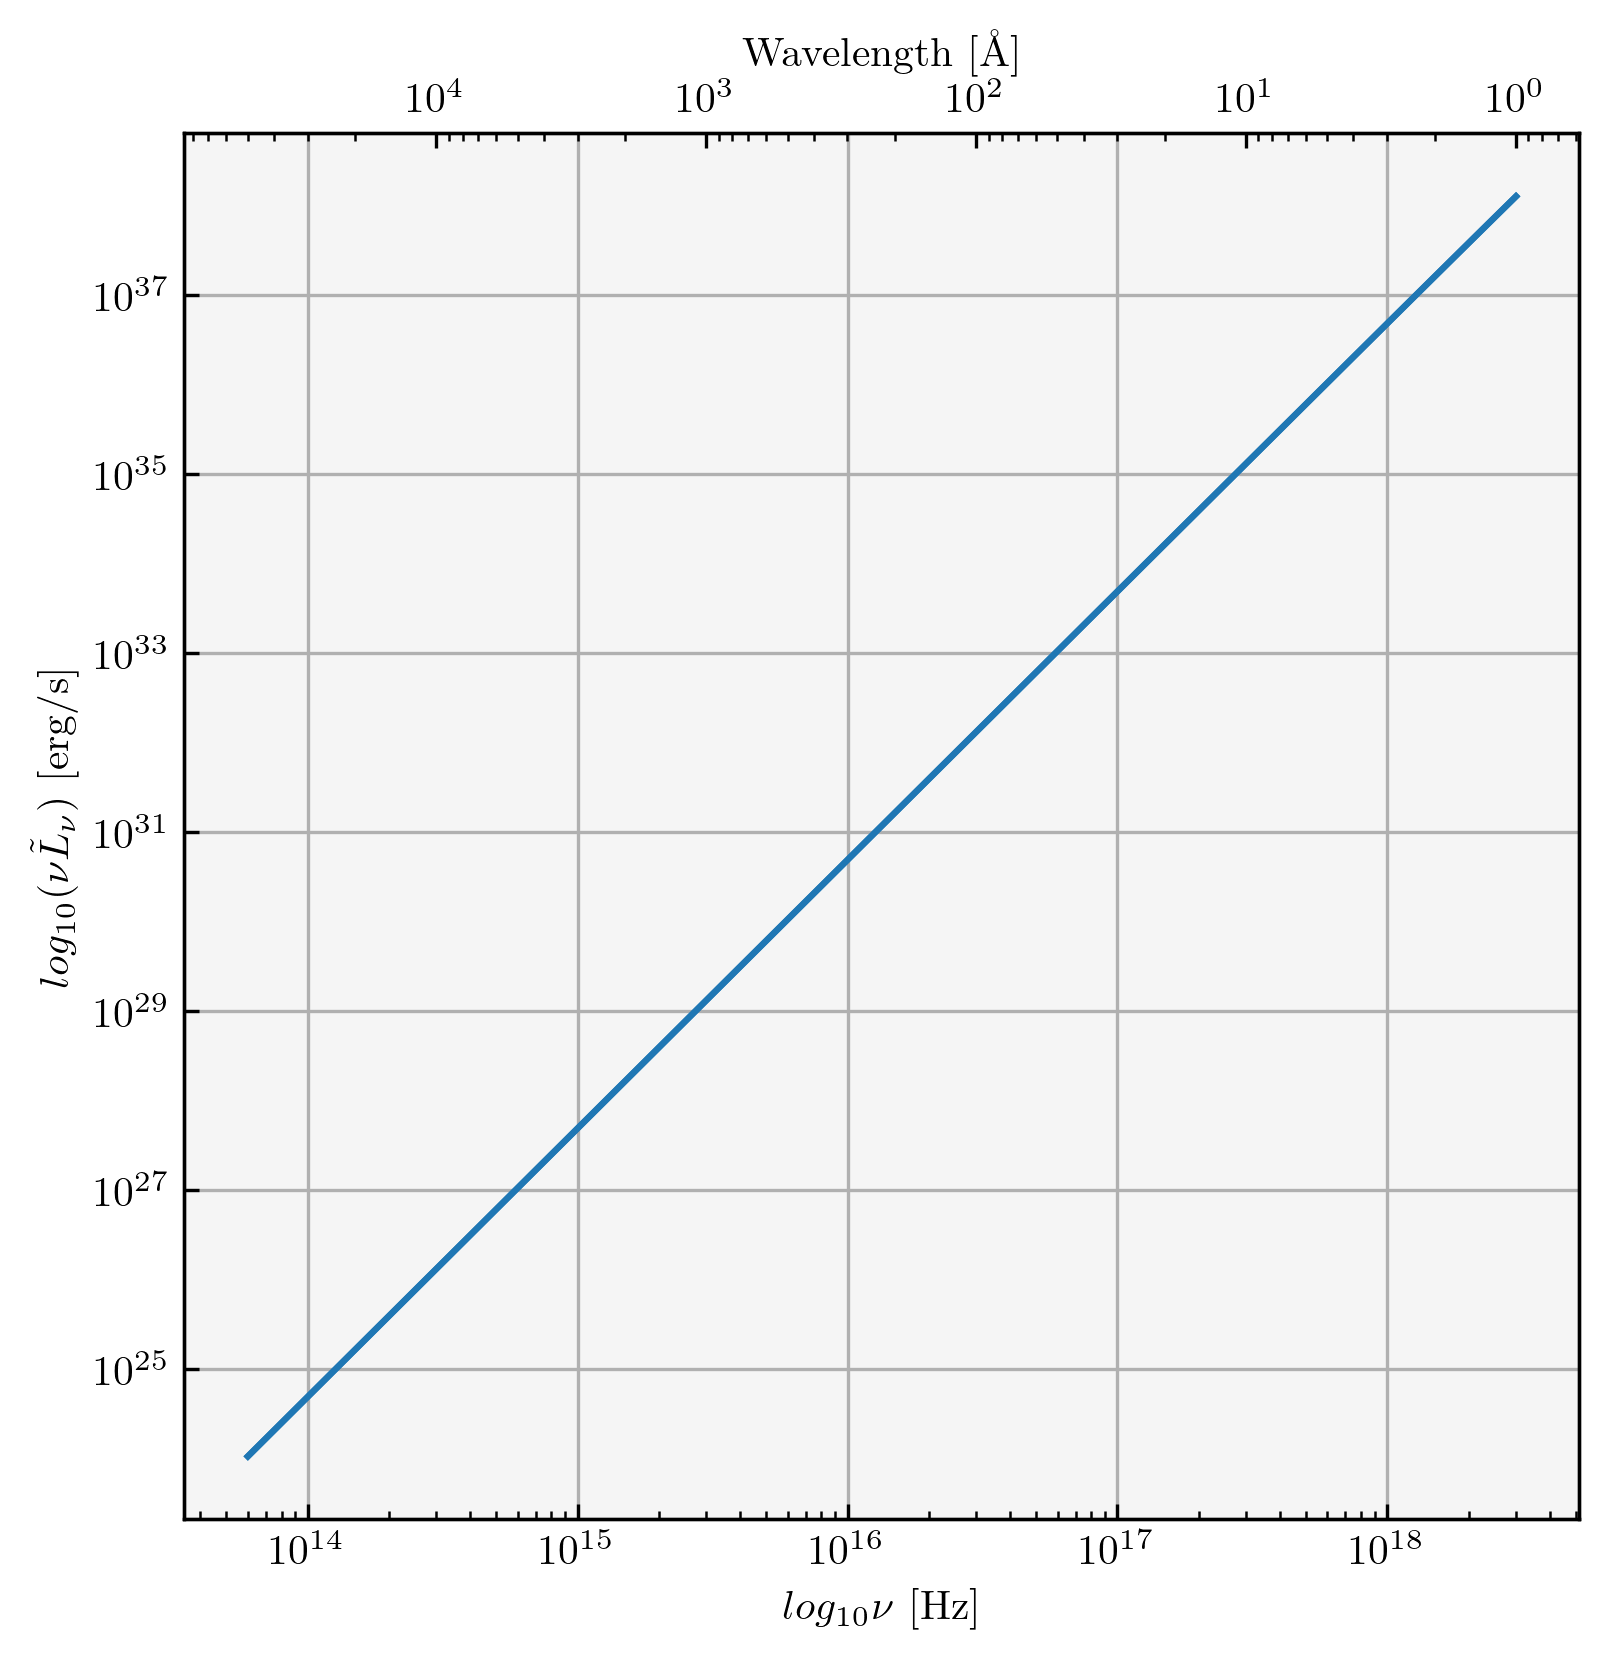

In [48]:
plt.figure( figsize=(4,5))


fig, ax1 = plt.subplots( figsize = (6,6) )
ax1.plot(n_arr, n_arr * lum_n)
ax2 = ax1.twiny()
ax1.set_xlabel(r'$log_{10}\nu$ [Hz]')
ax1.set_ylabel(r'$log_{10}(\nu\tilde{L}_\nu)$ [erg/s]')
ax1.loglog()
ax1.grid()
wavelength = np.divide(c, n_arr) * 1e8 # A
ax2.plot(wavelength, n_arr * lum_n)
ax2.invert_xaxis()
ax2.loglog()
ax2.set_xlabel(r'Wavelength [\AA]')
#plt.savefig('Figs/n_Ltildan_m' + str(m) + '_snap' + str(fix))
plt.show()